# This project implemented by Elham Mahdipour
## I am a Ph.D. Graduate  of computer engineering at Yazd University, Yazd, Iran.
## I am a Faculty Member of Computer Engineering Department at Khavaran Institute of Higher Education, Mashhad, Iran.
### Please feel free and contact to me: elham.mahdipour@gmail.com/ e.mahdipour@profs.khi.ac.ir

# Please run all cells for train the LSTM-NA model. This program train LSTM-NA for scerevisiae and AThaliana species.

# Phase 1 
## Create Dataset and Preprocessing

In [1]:
import networkx as nx
G1=nx.read_leda('biogrid samples\scerevisiae.gw')
G1

In [2]:
G2=nx.read_leda('biogrid samples\AThaliana.gw')
G2

In [3]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp
print(len(G1))
print(len(G2))

5831
5897


In [4]:
G_target_na=nx.read_weighted_edgelist('biogrid samples\sc-AT.tsv')
G_target_na  

In [5]:
len(G_target_na)

1440

In [5]:
ed1=G1.edges()
ed2=G2.edges()

nd1=G1.nodes()
nd2=G2.nodes()

el1=list(ed1)
el2=list(ed2)

nd1=list(nd1)
nd2=list(nd2)

degG1 = [val for (node, val) in G1.degree()]
degG2 = [val for (node, val) in G2.degree()]

# Feature Extraction

# compute score for create similarity matrix

In [6]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [7]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [8]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [9]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node

In [10]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [11]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [13]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=(nd1[i],nd2[j]) in elt
            if q1==False:
                c=0
            else:
               # print(q1)
                c=1
            seq[i][j]=c    
            
    return seq

In [14]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s,coeff_pr, dd, cd, seq_sc

In [15]:
import numpy as np
m, coeff_pr, dd, cd, seq=compute_score(G1,G2)
sim=m

# Phase 2: Dataset Generation

# create data for deep learning

# change problem to classification 
## [node of G1, node of G2, Sequence similarity, Coefficient page rank, clustering coefficient difference,  similarity score, alignment=yes(0)/TN or no(1)/TP]

In [16]:
# en_mat is encoding matrix
en_mat=[]

for i in range(len(nd1)):
    for j in range(len(nd2)):
        if G_target_na.has_edge(nd1[i],nd2[j]):
            align_class='Yes'
        else:
            align_class='No'
        
        sample=[int(nd1[i]),int(nd2[j]), seq[i][j], coeff_pr[i][j], dd[i][j],cd[i][j],sim[i][j],align_class] 
        en_mat.append(sample)
print(len(en_mat))

34385407


In [17]:
yc=[]
noc=[]
for i in range(len(en_mat)):
    if en_mat[i][7]=='Yes':
        yc.append(en_mat[i])
    else:
        noc.append(en_mat[i])
print(len(yc), len(noc))

265 34385142


# Solve data Imbalance problem

# Resample (Under-sampling)

In [18]:
noc.sort(key = lambda i: i[6])
data=yc+noc[0:len(yc)] 
len(data)
X=[]
y=[]
for i in range(len(data)):
    X.append(data[i][0:7])
    y.append(data[i][7])

len(X),len(y)

(530, 530)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [20]:
x_tr,y_tr,x_te,y_te=X_train, y_train,X_test,y_test

In [94]:
import pandas as pd
f=pd.DataFrame(en_mat,columns=['node_of_G1','node_of_G2', 'Sequence_Similarity','Coefficient_pagerank','Degree_Difference', 'clustering_coefficient_difference', 'similarity_score', 'alignment_class'])
f.head()

,node_of_G1,node_of_G2,Sequence_Similarity,Coefficient_pagerank,Degree_Difference,clustering_coefficient_difference,similarity_score,alignment_class
0,9164920,839248,0.0,0.671633,0.500000,0.686080,0.195621,No
1,9164920,839798,0.0,0.098354,0.857143,0.852643,0.148208,No
2,9164920,839799,0.0,0.277256,0.928571,0.982497,0.090061,No
3,9164920,839241,0.0,0.843618,0.222222,0.872006,0.196793,No
4,9164920,832578,0.0,0.147593,0.857143,0.289062,0.256000,No


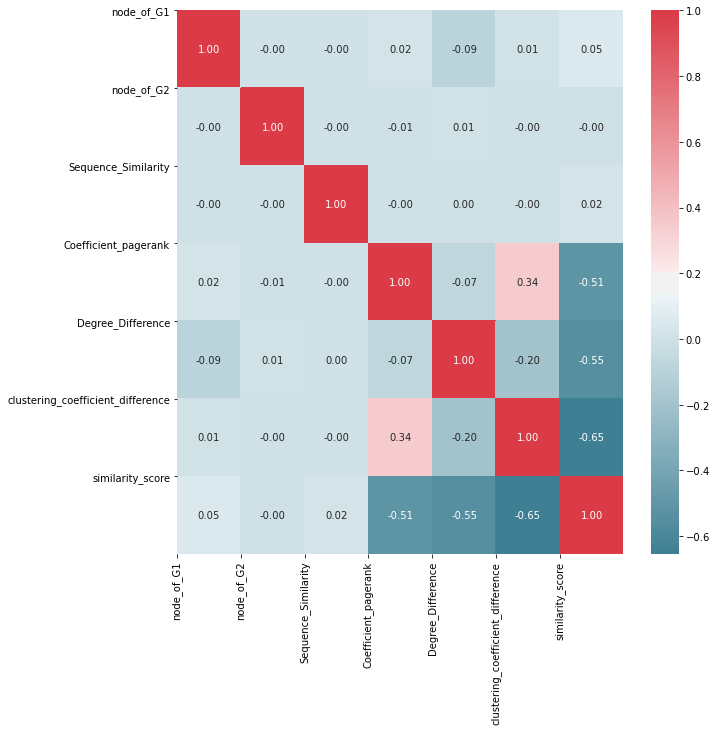

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#f=pd.DataFrame(X_train)
corr = f.corr()
   #Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map, red & blue
colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
plt.show()

# test model for real data

In [21]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# One Hot Encode
y_train = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [22]:
# Label encode Class (Species)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# One Hot Encode
y_test = np_utils.to_categorical(encoded_Y)

In [23]:
import numpy as np
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

# Phase 3: Architecture of LSTM-NA Network

# Train model with resample

In [25]:
#undersampling by delete no class data equal to yes class 
#without early stopping and with 1000 epoch
from keras import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras import layers
import keras
#callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc',patience=1,),
#keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,)]

model_lstm = Sequential()

model_lstm.add(layers.Embedding(7, 8))
model_lstm.add(layers.LSTM(4))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc','mae','mse'])
model_lstm.summary()
history_lstm = model_lstm.fit(X_train, y_train,epochs=1000,validation_split=0.2) #callbacks=callbacks_list

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           56        
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 274
Trainable params: 274
Non-trainable params: 0
_________________________________________________________________
Train on 381 samples, validate on 96 samples
Epoch 1/1000
381/381 [==============================] - 0s 959us/step - loss: 0.6937 - acc: 0.4226 - mae: 0.5003 - mse: 0.2503 - val_loss: 0.6935 - val_acc: 0.5000 - val_mae: 0.5002 - val_mse: 0.2502
Epoch 2/1000
381/381 [==============================] - 0s 202us/step - loss: 0.6935 - acc: 0.5197 - mae: 0.5002 - mse: 0.2502 - val_loss: 0.

Epoch 78/1000
381/381 [==============================] - 0s 191us/step - loss: 0.6853 - acc: 0.5197 - mae: 0.4957 - mse: 0.2461 - val_loss: 0.6861 - val_acc: 0.5000 - val_mae: 0.4963 - val_mse: 0.2465
Epoch 79/1000
381/381 [==============================] - 0s 206us/step - loss: 0.6851 - acc: 0.5197 - mae: 0.4957 - mse: 0.2460 - val_loss: 0.6859 - val_acc: 0.5000 - val_mae: 0.4962 - val_mse: 0.2464
Epoch 80/1000
381/381 [==============================] - 0s 205us/step - loss: 0.6851 - acc: 0.5197 - mae: 0.4957 - mse: 0.2460 - val_loss: 0.6857 - val_acc: 0.5000 - val_mae: 0.4961 - val_mse: 0.2463
Epoch 81/1000
381/381 [==============================] - 0s 202us/step - loss: 0.6849 - acc: 0.5197 - mae: 0.4957 - mse: 0.2459 - val_loss: 0.6855 - val_acc: 0.5000 - val_mae: 0.4960 - val_mse: 0.2462
Epoch 82/1000
381/381 [==============================] - 0s 209us/step - loss: 0.6844 - acc: 0.5197 - mae: 0.4954 - mse: 0.2456 - val_loss: 0.6853 - val_acc: 0.5000 - val_mae: 0.4959 - val_mse: 0.

Epoch 119/1000
381/381 [==============================] - 0s 178us/step - loss: 0.6705 - acc: 0.7270 - mae: 0.4884 - mse: 0.2387 - val_loss: 0.6708 - val_acc: 0.5000 - val_mae: 0.4886 - val_mse: 0.2388
Epoch 120/1000
381/381 [==============================] - 0s 188us/step - loss: 0.6699 - acc: 0.6955 - mae: 0.4881 - mse: 0.2384 - val_loss: 0.6701 - val_acc: 0.5000 - val_mae: 0.4882 - val_mse: 0.2385
Epoch 121/1000
381/381 [==============================] - 0s 188us/step - loss: 0.6690 - acc: 0.8346 - mae: 0.4876 - mse: 0.2379 - val_loss: 0.6694 - val_acc: 0.5000 - val_mae: 0.4879 - val_mse: 0.2382
Epoch 122/1000
381/381 [==============================] - 0s 175us/step - loss: 0.6686 - acc: 0.6562 - mae: 0.4874 - mse: 0.2377 - val_loss: 0.6687 - val_acc: 1.0000 - val_mae: 0.4875 - val_mse: 0.2378
Epoch 123/1000
381/381 [==============================] - 0s 175us/step - loss: 0.6676 - acc: 1.0000 - mae: 0.4870 - mse: 0.2372 - val_loss: 0.6681 - val_acc: 0.5000 - val_mae: 0.4871 - val_ms

Epoch 200/1000
381/381 [==============================] - 0s 217us/step - loss: 0.1122 - acc: 1.0000 - mae: 0.1059 - mse: 0.0116 - val_loss: 0.1104 - val_acc: 1.0000 - val_mae: 0.1043 - val_mse: 0.0114
Epoch 201/1000
381/381 [==============================] - 0s 181us/step - loss: 0.1074 - acc: 1.0000 - mae: 0.1016 - mse: 0.0108 - val_loss: 0.1058 - val_acc: 1.0000 - val_mae: 0.1002 - val_mse: 0.0104
Epoch 202/1000
381/381 [==============================] - 0s 181us/step - loss: 0.1030 - acc: 1.0000 - mae: 0.0977 - mse: 0.0099 - val_loss: 0.1017 - val_acc: 1.0000 - val_mae: 0.0964 - val_mse: 0.0097
Epoch 203/1000
381/381 [==============================] - 0s 181us/step - loss: 0.0990 - acc: 1.0000 - mae: 0.0940 - mse: 0.0092 - val_loss: 0.0977 - val_acc: 1.0000 - val_mae: 0.0929 - val_mse: 0.0090
Epoch 204/1000
381/381 [==============================] - 0s 186us/step - loss: 0.0952 - acc: 1.0000 - mae: 0.0906 - mse: 0.0086 - val_loss: 0.0940 - val_acc: 1.0000 - val_mae: 0.0895 - val_ms

381/381 [==============================] - 0s 180us/step - loss: 0.0217 - acc: 1.0000 - mae: 0.0214 - mse: 4.8900e-04 - val_loss: 0.0218 - val_acc: 1.0000 - val_mae: 0.0215 - val_mse: 4.9269e-04
Epoch 280/1000
381/381 [==============================] - 0s 178us/step - loss: 0.0214 - acc: 1.0000 - mae: 0.0212 - mse: 4.7848e-04 - val_loss: 0.0215 - val_acc: 1.0000 - val_mae: 0.0213 - val_mse: 4.8212e-04
Epoch 281/1000
381/381 [==============================] - 0s 178us/step - loss: 0.0212 - acc: 1.0000 - mae: 0.0210 - mse: 4.6850e-04 - val_loss: 0.0213 - val_acc: 1.0000 - val_mae: 0.0210 - val_mse: 4.7180e-04
Epoch 282/1000
381/381 [==============================] - 0s 173us/step - loss: 0.0210 - acc: 1.0000 - mae: 0.0207 - mse: 4.5836e-04 - val_loss: 0.0211 - val_acc: 1.0000 - val_mae: 0.0208 - val_mse: 4.6186e-04
Epoch 283/1000
381/381 [==============================] - 0s 181us/step - loss: 0.0207 - acc: 1.0000 - mae: 0.0205 - mse: 4.4914e-04 - val_loss: 0.0208 - val_acc: 1.0000 - val

Epoch 357/1000
381/381 [==============================] - 0s 181us/step - loss: 0.0114 - acc: 1.0000 - mae: 0.0113 - mse: 1.3657e-04 - val_loss: 0.0115 - val_acc: 1.0000 - val_mae: 0.0114 - val_mse: 1.3826e-04
Epoch 358/1000
381/381 [==============================] - 0s 183us/step - loss: 0.0113 - acc: 1.0000 - mae: 0.0112 - mse: 1.3484e-04 - val_loss: 0.0114 - val_acc: 1.0000 - val_mae: 0.0113 - val_mse: 1.3657e-04
Epoch 359/1000
381/381 [==============================] - 0s 175us/step - loss: 0.0112 - acc: 1.0000 - mae: 0.0112 - mse: 1.3322e-04 - val_loss: 0.0113 - val_acc: 1.0000 - val_mae: 0.0112 - val_mse: 1.3489e-04
Epoch 360/1000
381/381 [==============================] - 0s 186us/step - loss: 0.0112 - acc: 1.0000 - mae: 0.0111 - mse: 1.3158e-04 - val_loss: 0.0112 - val_acc: 1.0000 - val_mae: 0.0112 - val_mse: 1.3325e-04
Epoch 361/1000
381/381 [==============================] - 0s 175us/step - loss: 0.0111 - acc: 1.0000 - mae: 0.0110 - mse: 1.2999e-04 - val_loss: 0.0112 - val_ac

Epoch 396/1000
381/381 [==============================] - 0s 196us/step - loss: 0.0091 - acc: 1.0000 - mae: 0.0091 - mse: 8.7872e-05 - val_loss: 0.0092 - val_acc: 1.0000 - val_mae: 0.0091 - val_mse: 8.9058e-05
Epoch 397/1000
381/381 [==============================] - 0s 225us/step - loss: 0.0091 - acc: 1.0000 - mae: 0.0090 - mse: 8.6959e-05 - val_loss: 0.0091 - val_acc: 1.0000 - val_mae: 0.0091 - val_mse: 8.8152e-05
Epoch 398/1000
381/381 [==============================] - 0s 251us/step - loss: 0.0090 - acc: 1.0000 - mae: 0.0090 - mse: 8.6084e-05 - val_loss: 0.0091 - val_acc: 1.0000 - val_mae: 0.0090 - val_mse: 8.7262e-05
Epoch 399/1000
381/381 [==============================] - 0s 204us/step - loss: 0.0090 - acc: 1.0000 - mae: 0.0089 - mse: 8.5218e-05 - val_loss: 0.0090 - val_acc: 1.0000 - val_mae: 0.0090 - val_mse: 8.6381e-05
Epoch 400/1000
381/381 [==============================] - 0s 199us/step - loss: 0.0089 - acc: 1.0000 - mae: 0.0089 - mse: 8.4364e-05 - val_loss: 0.0090 - val_ac

381/381 [==============================] - 0s 202us/step - loss: 0.0076 - acc: 1.0000 - mae: 0.0075 - mse: 6.0787e-05 - val_loss: 0.0076 - val_acc: 1.0000 - val_mae: 0.0076 - val_mse: 6.1668e-05
Epoch 436/1000
381/381 [==============================] - 0s 196us/step - loss: 0.0075 - acc: 1.0000 - mae: 0.0075 - mse: 6.0261e-05 - val_loss: 0.0076 - val_acc: 1.0000 - val_mae: 0.0076 - val_mse: 6.1138e-05
Epoch 437/1000
381/381 [==============================] - 0s 186us/step - loss: 0.0075 - acc: 1.0000 - mae: 0.0075 - mse: 5.9743e-05 - val_loss: 0.0076 - val_acc: 1.0000 - val_mae: 0.0075 - val_mse: 6.0611e-05
Epoch 438/1000
381/381 [==============================] - 0s 217us/step - loss: 0.0075 - acc: 1.0000 - mae: 0.0074 - mse: 5.9228e-05 - val_loss: 0.0075 - val_acc: 1.0000 - val_mae: 0.0075 - val_mse: 6.0091e-05
Epoch 439/1000
381/381 [==============================] - 0s 217us/step - loss: 0.0074 - acc: 1.0000 - mae: 0.0074 - mse: 5.8720e-05 - val_loss: 0.0075 - val_acc: 1.0000 - val

381/381 [==============================] - 0s 277us/step - loss: 0.0056 - acc: 1.0000 - mae: 0.0056 - mse: 3.3587e-05 - val_loss: 0.0057 - val_acc: 1.0000 - val_mae: 0.0057 - val_mse: 3.4106e-05
Epoch 514/1000
381/381 [==============================] - 0s 241us/step - loss: 0.0056 - acc: 1.0000 - mae: 0.0056 - mse: 3.3361e-05 - val_loss: 0.0057 - val_acc: 1.0000 - val_mae: 0.0056 - val_mse: 3.3879e-05
Epoch 515/1000
381/381 [==============================] - 0s 230us/step - loss: 0.0056 - acc: 1.0000 - mae: 0.0056 - mse: 3.3141e-05 - val_loss: 0.0056 - val_acc: 1.0000 - val_mae: 0.0056 - val_mse: 3.3655e-05
Epoch 516/1000
381/381 [==============================] - 0s 267us/step - loss: 0.0056 - acc: 1.0000 - mae: 0.0056 - mse: 3.2921e-05 - val_loss: 0.0056 - val_acc: 1.0000 - val_mae: 0.0056 - val_mse: 3.3432e-05
Epoch 517/1000
381/381 [==============================] - 0s 343us/step - loss: 0.0056 - acc: 1.0000 - mae: 0.0055 - mse: 3.2704e-05 - val_loss: 0.0056 - val_acc: 1.0000 - val

Epoch 552/1000
381/381 [==============================] - 0s 259us/step - loss: 0.0050 - acc: 1.0000 - mae: 0.0050 - mse: 2.6252e-05 - val_loss: 0.0050 - val_acc: 1.0000 - val_mae: 0.0050 - val_mse: 2.6667e-05
Epoch 553/1000
381/381 [==============================] - 0s 293us/step - loss: 0.0050 - acc: 1.0000 - mae: 0.0049 - mse: 2.6094e-05 - val_loss: 0.0050 - val_acc: 1.0000 - val_mae: 0.0050 - val_mse: 2.6508e-05
Epoch 554/1000
381/381 [==============================] - 0s 283us/step - loss: 0.0049 - acc: 1.0000 - mae: 0.0049 - mse: 2.5938e-05 - val_loss: 0.0050 - val_acc: 1.0000 - val_mae: 0.0050 - val_mse: 2.6351e-05
Epoch 555/1000
381/381 [==============================] - 0s 238us/step - loss: 0.0049 - acc: 1.0000 - mae: 0.0049 - mse: 2.5787e-05 - val_loss: 0.0050 - val_acc: 1.0000 - val_mae: 0.0050 - val_mse: 2.6195e-05
Epoch 556/1000
381/381 [==============================] - 0s 259us/step - loss: 0.0049 - acc: 1.0000 - mae: 0.0049 - mse: 2.5635e-05 - val_loss: 0.0050 - val_ac

381/381 [==============================] - 0s 200us/step - loss: 0.0045 - acc: 1.0000 - mae: 0.0044 - mse: 2.1031e-05 - val_loss: 0.0045 - val_acc: 1.0000 - val_mae: 0.0045 - val_mse: 2.1370e-05
Epoch 592/1000
381/381 [==============================] - 0s 238us/step - loss: 0.0044 - acc: 1.0000 - mae: 0.0044 - mse: 2.0918e-05 - val_loss: 0.0045 - val_acc: 1.0000 - val_mae: 0.0045 - val_mse: 2.1254e-05
Epoch 593/1000
381/381 [==============================] - 0s 205us/step - loss: 0.0044 - acc: 1.0000 - mae: 0.0044 - mse: 2.0805e-05 - val_loss: 0.0045 - val_acc: 1.0000 - val_mae: 0.0045 - val_mse: 2.1141e-05
Epoch 594/1000
381/381 [==============================] - 0s 183us/step - loss: 0.0044 - acc: 1.0000 - mae: 0.0044 - mse: 2.0694e-05 - val_loss: 0.0045 - val_acc: 1.0000 - val_mae: 0.0044 - val_mse: 2.1028e-05
Epoch 595/1000
381/381 [==============================] - 0s 191us/step - loss: 0.0044 - acc: 1.0000 - mae: 0.0044 - mse: 2.0584e-05 - val_loss: 0.0044 - val_acc: 1.0000 - val

381/381 [==============================] - 0s 202us/step - loss: 0.0037 - acc: 1.0000 - mae: 0.0037 - mse: 1.4292e-05 - val_loss: 0.0037 - val_acc: 1.0000 - val_mae: 0.0037 - val_mse: 1.4527e-05
Epoch 670/1000
381/381 [==============================] - 0s 191us/step - loss: 0.0037 - acc: 1.0000 - mae: 0.0037 - mse: 1.4227e-05 - val_loss: 0.0037 - val_acc: 1.0000 - val_mae: 0.0037 - val_mse: 1.4461e-05
Epoch 671/1000
381/381 [==============================] - 0s 217us/step - loss: 0.0037 - acc: 1.0000 - mae: 0.0036 - mse: 1.4162e-05 - val_loss: 0.0037 - val_acc: 1.0000 - val_mae: 0.0037 - val_mse: 1.4395e-05
Epoch 672/1000
381/381 [==============================] - 0s 194us/step - loss: 0.0036 - acc: 1.0000 - mae: 0.0036 - mse: 1.4099e-05 - val_loss: 0.0037 - val_acc: 1.0000 - val_mae: 0.0037 - val_mse: 1.4331e-05
Epoch 673/1000
381/381 [==============================] - 0s 191us/step - loss: 0.0036 - acc: 1.0000 - mae: 0.0036 - mse: 1.4035e-05 - val_loss: 0.0037 - val_acc: 1.0000 - val

381/381 [==============================] - 0s 209us/step - loss: 0.0031 - acc: 1.0000 - mae: 0.0031 - mse: 1.0285e-05 - val_loss: 0.0031 - val_acc: 1.0000 - val_mae: 0.0031 - val_mse: 1.0457e-05
Epoch 748/1000
381/381 [==============================] - 0s 202us/step - loss: 0.0031 - acc: 1.0000 - mae: 0.0031 - mse: 1.0246e-05 - val_loss: 0.0031 - val_acc: 1.0000 - val_mae: 0.0031 - val_mse: 1.0416e-05
Epoch 749/1000
381/381 [==============================] - 0s 196us/step - loss: 0.0031 - acc: 1.0000 - mae: 0.0031 - mse: 1.0205e-05 - val_loss: 0.0031 - val_acc: 1.0000 - val_mae: 0.0031 - val_mse: 1.0375e-05
Epoch 750/1000
381/381 [==============================] - 0s 215us/step - loss: 0.0031 - acc: 1.0000 - mae: 0.0031 - mse: 1.0167e-05 - val_loss: 0.0031 - val_acc: 1.0000 - val_mae: 0.0031 - val_mse: 1.0335e-05
Epoch 751/1000
381/381 [==============================] - 0s 237us/step - loss: 0.0031 - acc: 1.0000 - mae: 0.0031 - mse: 1.0126e-05 - val_loss: 0.0031 - val_acc: 1.0000 - val

Epoch 786/1000
381/381 [==============================] - 0s 199us/step - loss: 0.0029 - acc: 1.0000 - mae: 0.0029 - mse: 8.8729e-06 - val_loss: 0.0029 - val_acc: 1.0000 - val_mae: 0.0029 - val_mse: 9.0208e-06
Epoch 787/1000
381/381 [==============================] - 0s 199us/step - loss: 0.0029 - acc: 1.0000 - mae: 0.0029 - mse: 8.8403e-06 - val_loss: 0.0029 - val_acc: 1.0000 - val_mae: 0.0029 - val_mse: 8.9881e-06
Epoch 788/1000
381/381 [==============================] - 0s 212us/step - loss: 0.0029 - acc: 1.0000 - mae: 0.0029 - mse: 8.8082e-06 - val_loss: 0.0029 - val_acc: 1.0000 - val_mae: 0.0029 - val_mse: 8.9554e-06
Epoch 789/1000
381/381 [==============================] - 0s 196us/step - loss: 0.0029 - acc: 1.0000 - mae: 0.0029 - mse: 8.7758e-06 - val_loss: 0.0029 - val_acc: 1.0000 - val_mae: 0.0029 - val_mse: 8.9229e-06
Epoch 790/1000
381/381 [==============================] - 0s 223us/step - loss: 0.0029 - acc: 1.0000 - mae: 0.0029 - mse: 8.7453e-06 - val_loss: 0.0029 - val_ac

381/381 [==============================] - 0s 207us/step - loss: 0.0027 - acc: 1.0000 - mae: 0.0027 - mse: 7.7261e-06 - val_loss: 0.0027 - val_acc: 1.0000 - val_mae: 0.0027 - val_mse: 7.8554e-06
Epoch 826/1000
381/381 [==============================] - 0s 259us/step - loss: 0.0027 - acc: 1.0000 - mae: 0.0027 - mse: 7.6992e-06 - val_loss: 0.0027 - val_acc: 1.0000 - val_mae: 0.0027 - val_mse: 7.8285e-06
Epoch 827/1000
381/381 [==============================] - 0s 249us/step - loss: 0.0027 - acc: 1.0000 - mae: 0.0027 - mse: 7.6734e-06 - val_loss: 0.0027 - val_acc: 1.0000 - val_mae: 0.0027 - val_mse: 7.8015e-06
Epoch 828/1000
381/381 [==============================] - 0s 240us/step - loss: 0.0027 - acc: 1.0000 - mae: 0.0027 - mse: 7.6469e-06 - val_loss: 0.0027 - val_acc: 1.0000 - val_mae: 0.0027 - val_mse: 7.7748e-06
Epoch 829/1000
381/381 [==============================] - 0s 254us/step - loss: 0.0027 - acc: 1.0000 - mae: 0.0027 - mse: 7.6207e-06 - val_loss: 0.0027 - val_acc: 1.0000 - val

381/381 [==============================] - 0s 202us/step - loss: 0.0024 - acc: 1.0000 - mae: 0.0024 - mse: 5.9972e-06 - val_loss: 0.0024 - val_acc: 1.0000 - val_mae: 0.0024 - val_mse: 6.0982e-06
Epoch 904/1000
381/381 [==============================] - 0s 202us/step - loss: 0.0024 - acc: 1.0000 - mae: 0.0024 - mse: 5.9788e-06 - val_loss: 0.0024 - val_acc: 1.0000 - val_mae: 0.0024 - val_mse: 6.0795e-06
Epoch 905/1000
381/381 [==============================] - 0s 199us/step - loss: 0.0024 - acc: 1.0000 - mae: 0.0024 - mse: 5.9604e-06 - val_loss: 0.0024 - val_acc: 1.0000 - val_mae: 0.0024 - val_mse: 6.0610e-06
Epoch 906/1000
381/381 [==============================] - 0s 199us/step - loss: 0.0024 - acc: 1.0000 - mae: 0.0024 - mse: 5.9425e-06 - val_loss: 0.0024 - val_acc: 1.0000 - val_mae: 0.0024 - val_mse: 6.0423e-06
Epoch 907/1000
381/381 [==============================] - 0s 196us/step - loss: 0.0024 - acc: 1.0000 - mae: 0.0024 - mse: 5.9241e-06 - val_loss: 0.0024 - val_acc: 1.0000 - val

381/381 [==============================] - 0s 196us/step - loss: 0.0021 - acc: 1.0000 - mae: 0.0021 - mse: 4.7788e-06 - val_loss: 0.0021 - val_acc: 1.0000 - val_mae: 0.0021 - val_mse: 4.8596e-06
Epoch 982/1000
381/381 [==============================] - 0s 196us/step - loss: 0.0021 - acc: 1.0000 - mae: 0.0021 - mse: 4.7658e-06 - val_loss: 0.0021 - val_acc: 1.0000 - val_mae: 0.0021 - val_mse: 4.8461e-06
Epoch 983/1000
381/381 [==============================] - 0s 194us/step - loss: 0.0021 - acc: 1.0000 - mae: 0.0021 - mse: 4.7527e-06 - val_loss: 0.0021 - val_acc: 1.0000 - val_mae: 0.0021 - val_mse: 4.8327e-06
Epoch 984/1000
381/381 [==============================] - 0s 202us/step - loss: 0.0021 - acc: 1.0000 - mae: 0.0021 - mse: 4.7395e-06 - val_loss: 0.0021 - val_acc: 1.0000 - val_mae: 0.0021 - val_mse: 4.8195e-06
Epoch 985/1000
381/381 [==============================] - 0s 196us/step - loss: 0.0021 - acc: 1.0000 - mae: 0.0021 - mse: 4.7265e-06 - val_loss: 0.0021 - val_acc: 1.0000 - val

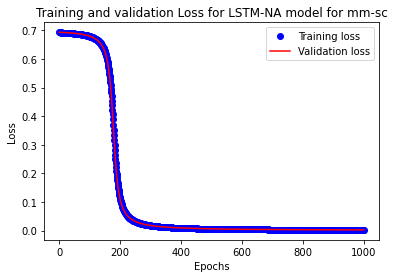

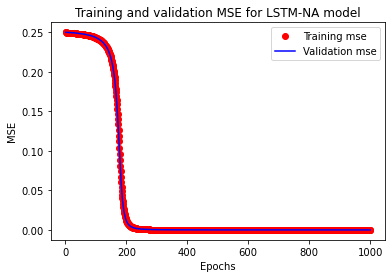

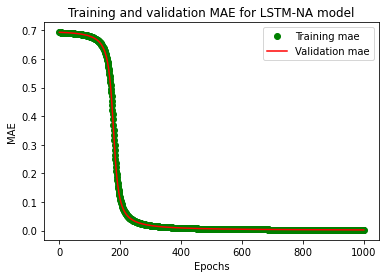

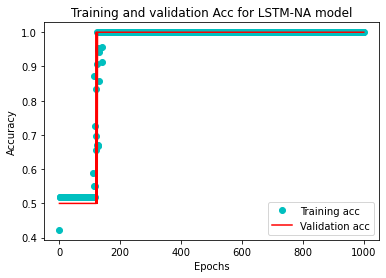

In [28]:
import matplotlib.pyplot as plt
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
mse = history_lstm.history['mse']
val_mse = history_lstm.history['val_mse']
mae = history_lstm.history['mae']
val_mae = history_lstm.history['val_mae']
acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation Loss for LSTM-NA model for mm-SC')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, mse, 'ro', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and validation MSE for LSTM-NA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'go', label='Training mae')
plt.plot(epochs, val_loss, 'r', label='Validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and validation MAE for LSTM-NA model')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation Acc for LSTM-NA model')
plt.legend()
plt.show()


In [29]:
# save model
import h5py
model_lstm.save('biogrid samples/deep_model_undersample_lstm_SC-AT.h5')
model_lstm.save_weights('biogrid samples/deep_model_undersample_lstm_weights_SC-AT.h5')

In [87]:
%%time
out_te=model_lstm.predict(X_test)
out_te

Wall time: 2min 43s


array([[9.999931e-01, 6.943173e-06],
       [9.999931e-01, 6.943173e-06],
       [9.999931e-01, 6.943173e-06],
       ...,
       [9.999931e-01, 6.943173e-06],
       [9.999931e-01, 6.943173e-06],
       [9.999931e-01, 6.943173e-06]], dtype=float32)

In [88]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), out_te.argmax(axis=1)))

[[3438520       0]
 [      0      21]]


In [89]:
#1000 epoch
from sklearn.metrics import f1_score, precision_score, recall_score

print(precision_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))

1.0
1.0
1.0


# Train LSTM model for real data (without resample)

In [33]:
from keras import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras import layers
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc',patience=1,),
keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True,)]

model_lstm = Sequential()

model_lstm.add(layers.Embedding(6, 8))
model_lstm.add(layers.LSTM(4))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc','mae','mse'])
model_lstm.summary()
history_lstm = model_lstm.fit(X_train, y_train,epochs=2,validation_split=0.2, callbacks=callbacks_list)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           48        
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________
Train on 20307200 samples, validate on 5076800 samples
Epoch 1/2
20307200/20307200 [==============================] - 3979s 196us/step - loss: 0.0016 - acc: 0.9999 - mae: 5.7148e-04 - mse: 1.8825e-04 - val_loss: 0.0011 - val_acc: 0.9998 - val_mae: 3.0702e-04 - val_mse: 1.5160e-04
Epoch 2/2
20307200/20307200 [==============================] - 3954s 195us/step - loss: 0.0016 - acc: 0.9

In [34]:
# save model
import h5py
model_lstm.save('large dataset/deep_model_before_resample_6features_lstm_ec-sc.h5')
model_lstm.save_weights('large dataset/deep_model_before_resample_6features_lstm_weights_ec-sc.h5')

## Test Tune model for real data (without resample)

In [26]:
from keras.models import load_model
#del model
model_lstm = load_model('large dataset/deep_model_before_resample_6features_lstm_ec-sc.h5')
model_lstm.load_weights('large dataset/deep_model_before_resample_6features_lstm_weights_ec-sc.h5', by_name=True)

In [36]:
# without resample
result_tr = model_lstm.evaluate(X_train, y_train)
result_tr

25384000/25384000 [==============================] - 2011s 79us/step


[0.0017920834103681668,
 0.99989253282547,
 0.0007473152363672853,
 0.00016190006863325834]

In [37]:
%%time
out_tr=model_lstm.predict(X_train)
out_tr

Wall time: 21min 11s


array([[9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       ...,
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04]], dtype=float32)

In [38]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train.argmax(axis=1), out_tr.argmax(axis=1)))

[[25379886        0]
 [    4114        0]]


In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))
print(recall_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))
print(f1_score(y_train.argmax(axis=1), out_tr.argmax(axis=1) , average="macro"))

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4999189647021746
0.5
0.49995947906746147


In [40]:
# without resample
result_te = model_lstm.evaluate(X_test, y_test)
result_te

2820445/2820445 [==============================] - 214s 76us/step


[0.001765404671098096,
 0.9998415112495422,
 0.0007448680698871613,
 0.000158529554028064]

In [41]:
%%time
out_te=model_lstm.predict(X_test)
out_te

Wall time: 2min 22s


array([[9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       ...,
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858662e-04],
       [9.994142e-01, 5.858660e-04]], dtype=float32)

In [42]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), out_te.argmax(axis=1)))

[[2819998       0]
 [    447       0]]


In [43]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(precision_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(recall_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))
print(f1_score(y_test.argmax(axis=1), out_te.argmax(axis=1) , average="macro"))

0.49992075718547957
0.5
0.49996037545277916


# test other classifier without resample

In [52]:
x_tra,y_tra,x_tes,y_tes=X_train,y_train,X_test,y_test

In [53]:
X_train,y_train,X_test,y_test=x_tr,y_tr,x_te,y_te

In [90]:
%%time
# Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 1.00
Accuracy of LDA classifier on test set: 1.00
Wall time: 3min 35s


In [91]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix, accuracy_score
# Make predictions
preds_tr = lda.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999929556679503
[[30946638        0]
 [     218       10]]
0.999996477832837
0.5219298245614035
0.5420150456329047
Wall time: 4min 49s


In [92]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix, accuracy_score
# Make predictions
preds = lda.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999901120853292
[[3438504       0]
 [     34       3]]
0.9999950560383513
0.5405405405405406
0.5749975280069541
Wall time: 30.3 s


In [93]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

Wall time: 5min 43s
KNeighborsClassifier()


In [94]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
# Make predictions
preds_tr = knn.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999926325334526
[[30946638        0]
 [     228        0]]
0.4999963162667263
0.5
0.4999981581265782
Wall time: 22min 42s


In [95]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
# Make predictions
preds =  knn.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.99998923962227
[[3438504       0]
 [     37       0]]
0.499994619811135
0.5
0.4999973098910942
Wall time: 2min 27s


In [96]:
%%time
# SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 1.00
Wall time: 12min 28s


In [97]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds_tr = svm.predict(X_train)
print(preds_tr)

# Evaluate accuracy
print(accuracy_score(y_train, preds_tr))

print(confusion_matrix(y_train, preds_tr))
print(precision_score(y_train, preds_tr , average="macro"))
print(recall_score(y_train, preds_tr , average="macro"))
print(f1_score(y_train, preds_tr , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.9999926325334526
[[30946638        0]
 [     228        0]]
0.4999963162667263
0.5
0.4999981581265782
Wall time: 8min 33s


In [98]:
%%time
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,accuracy_score
# Make predictions
preds = svm.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

print(confusion_matrix(y_test, preds))
print(precision_score(y_test, preds , average="macro"))
print(recall_score(y_test, preds , average="macro"))
print(f1_score(y_test, preds , average="macro"))

['No' 'No' 'No' ... 'No' 'No' 'No']
0.99998923962227
[[3438504       0]
 [     37       0]]
0.499994619811135
0.5
0.4999973098910942
Wall time: 55.3 s
